In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')


In [9]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter


In [10]:
from google.colab import files
files.upload()  # Select kaggle.json from your computer


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"parthlawand","key":"cc9ddd430a7fee388b5a80b1a6aa3a97"}'}

In [11]:
import os

# Make a Kaggle directory and move kaggle.json there
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Set permissions
!chmod 600 ~/.kaggle/kaggle.json


In [12]:
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images


Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images
License(s): CC-BY-SA-4.0
100% 1.76G/1.76G [00:24<00:00, 77.7MB/s]
100% 1.76G/1.76G [00:24<00:00, 76.6MB/s]


In [13]:
from zipfile import ZipFile

# Unzip the downloaded file
dataset_path = "lung-and-colon-cancer-histopathological-images.zip"

with ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall("lung_cancer_data")  # Extract to a folder
    print("Dataset extracted successfully!")


Dataset extracted successfully!


In [14]:
import os

# List extracted files
print(os.listdir("lung_cancer_data"))


['lung_colon_image_set']


In [15]:
import os

# Define the correct path
dataset_path = "lung_cancer_data/lung_colon_image_set"

# List the actual class folders
classes = os.listdir(dataset_path)
print("Classes in the dataset:", classes)


Classes in the dataset: ['colon_image_sets', 'lung_image_sets']


In [16]:
import os

# Paths to colon and lung image sets
colon_path = "lung_cancer_data/lung_colon_image_set/colon_image_sets"
lung_path = "lung_cancer_data/lung_colon_image_set/lung_image_sets"

# Get class names
colon_classes = os.listdir(colon_path)
lung_classes = os.listdir(lung_path)

print("Colon Cancer Classes:", colon_classes)
print("Lung Cancer Classes:", lung_classes)


Colon Cancer Classes: ['colon_aca', 'colon_n']
Lung Cancer Classes: ['lung_scc', 'lung_aca', 'lung_n']


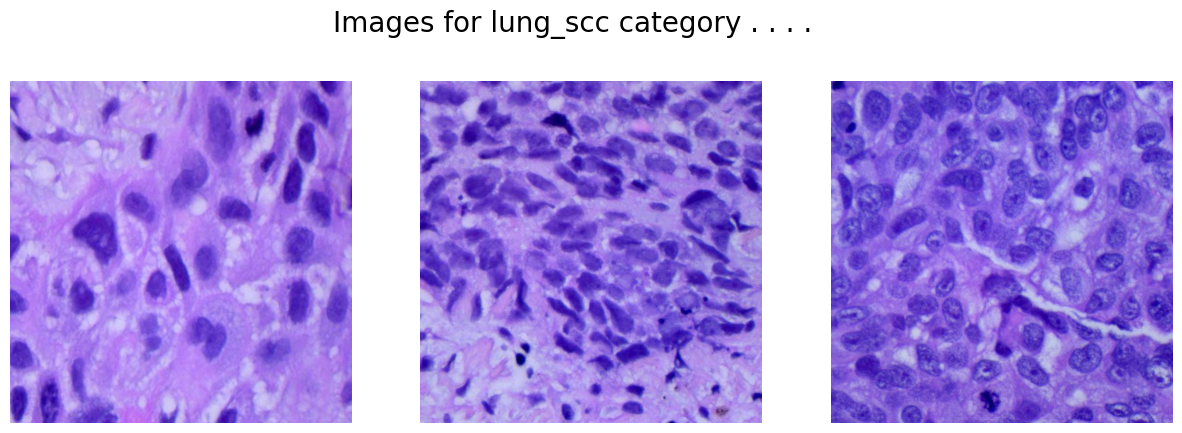

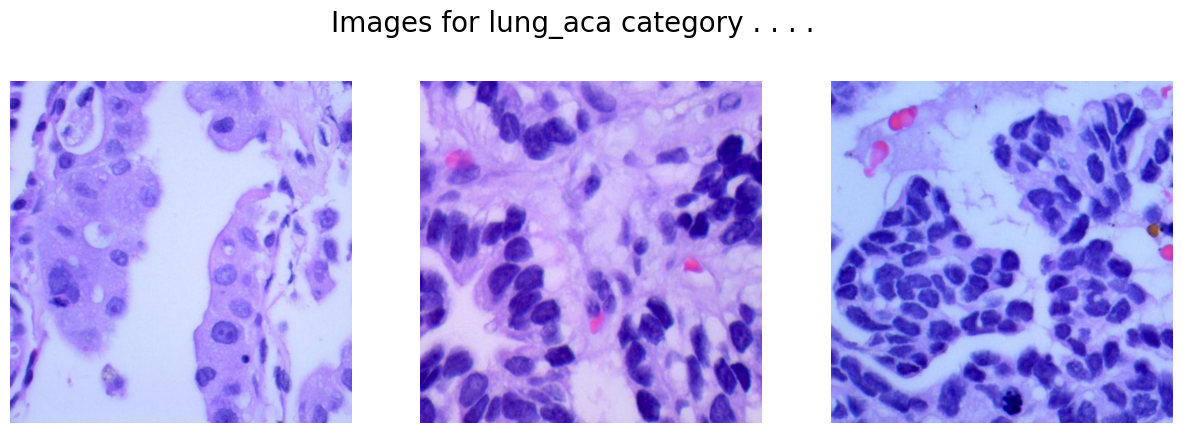

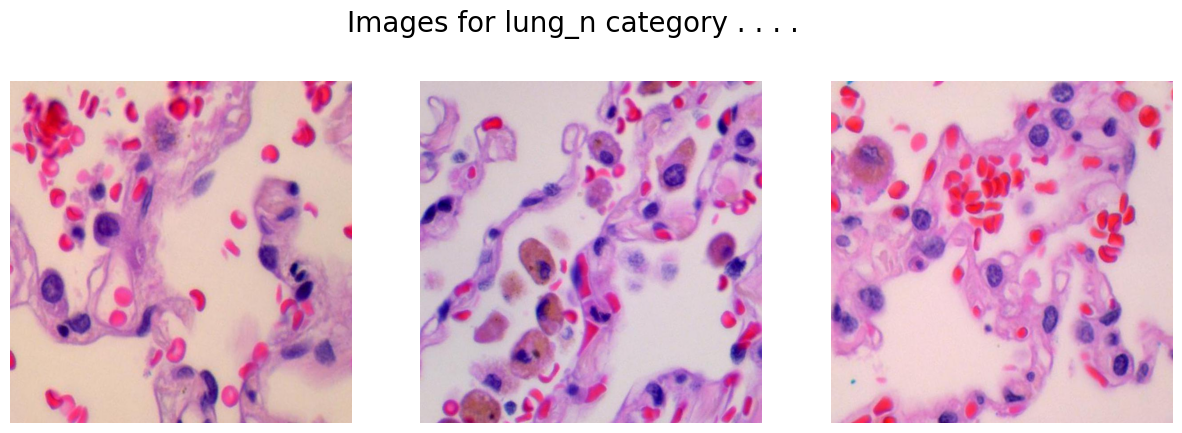

In [17]:
for cat in lung_classes:  # Loop through only lung classes
    image_dir = os.path.join(lung_path, cat)
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)

    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(os.path.join(image_dir, images[k])))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()


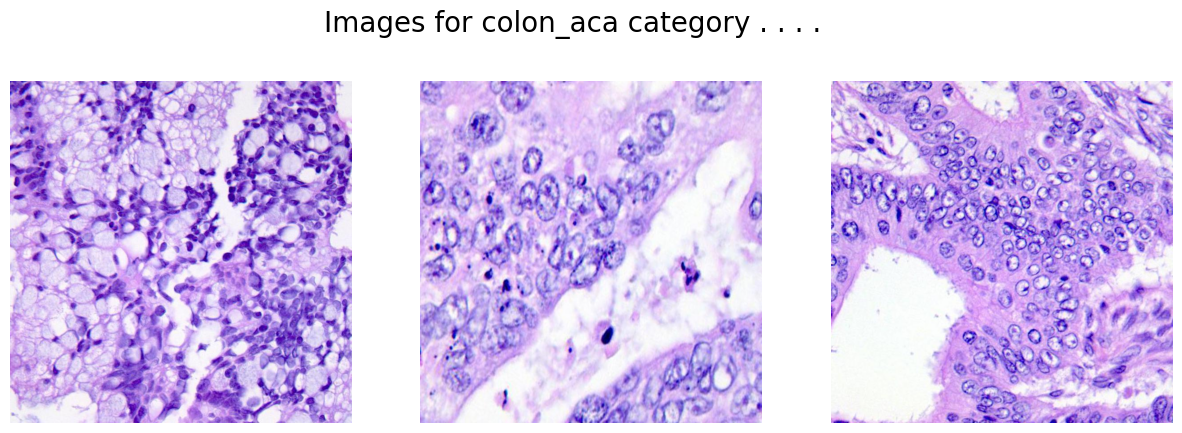

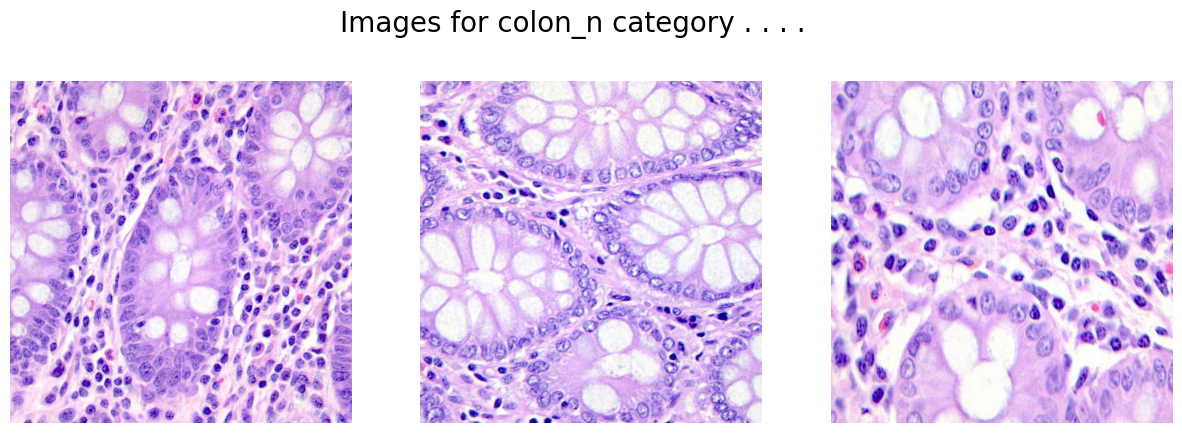

In [18]:
for cat in colon_classes:  # Loop through only colon classes
    image_dir = os.path.join(colon_path, cat)
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)

    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(os.path.join(image_dir, images[k])))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()


In [19]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64


In [20]:
# Paths to the lung image sets
lung_path = 'lung_cancer_data/lung_colon_image_set/lung_image_sets'

# Categories in lung_image_sets
lung_categories = ['lung_aca', 'lung_scc', 'lung_n']

# Prepare the data
X = []
Y = []

for i, cat in enumerate(lung_categories):
    # Get the images in each category
    images = glob(f'{lung_path}/{cat}/*.jpeg')
    print(f"Number of images found in {cat}: {len(images)}")  # Debugging print

    for image in images:
        img = cv2.imread(image)  # Read the image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))  # Resize image to IMG_SIZE
        Y.append(i)  # Append the label (category index)

# Convert X and Y to numpy arrays
X = np.asarray(X)
Y = np.asarray(Y)

# One-hot encode the labels
one_hot_encoded_Y = pd.get_dummies(Y).values

# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y,
                                                  test_size=SPLIT,
                                                  random_state=2022)

# Print shapes to confirm the data split
print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)


Number of images found in lung_aca: 5000


KeyboardInterrupt: 

In [14]:
# Define the CNN model architecture
model = keras.models.Sequential([
    layers.Conv2D(filters=32,
                  kernel_size=(5, 5),
                  activation='relu',
                  input_shape=(IMG_SIZE, IMG_SIZE, 3),
                  padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(filters=64,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(filters=128,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(3, activation='softmax')  # Output layer for 3 classes (lung_aca, lung_scc, lung_n)
])



In [15]:

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      33,554,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,684,291 (128.50 MB)

 Trainable params: 33,683,523 (128.49 MB)

 Non-trainable params: 768 (3.00 KB)

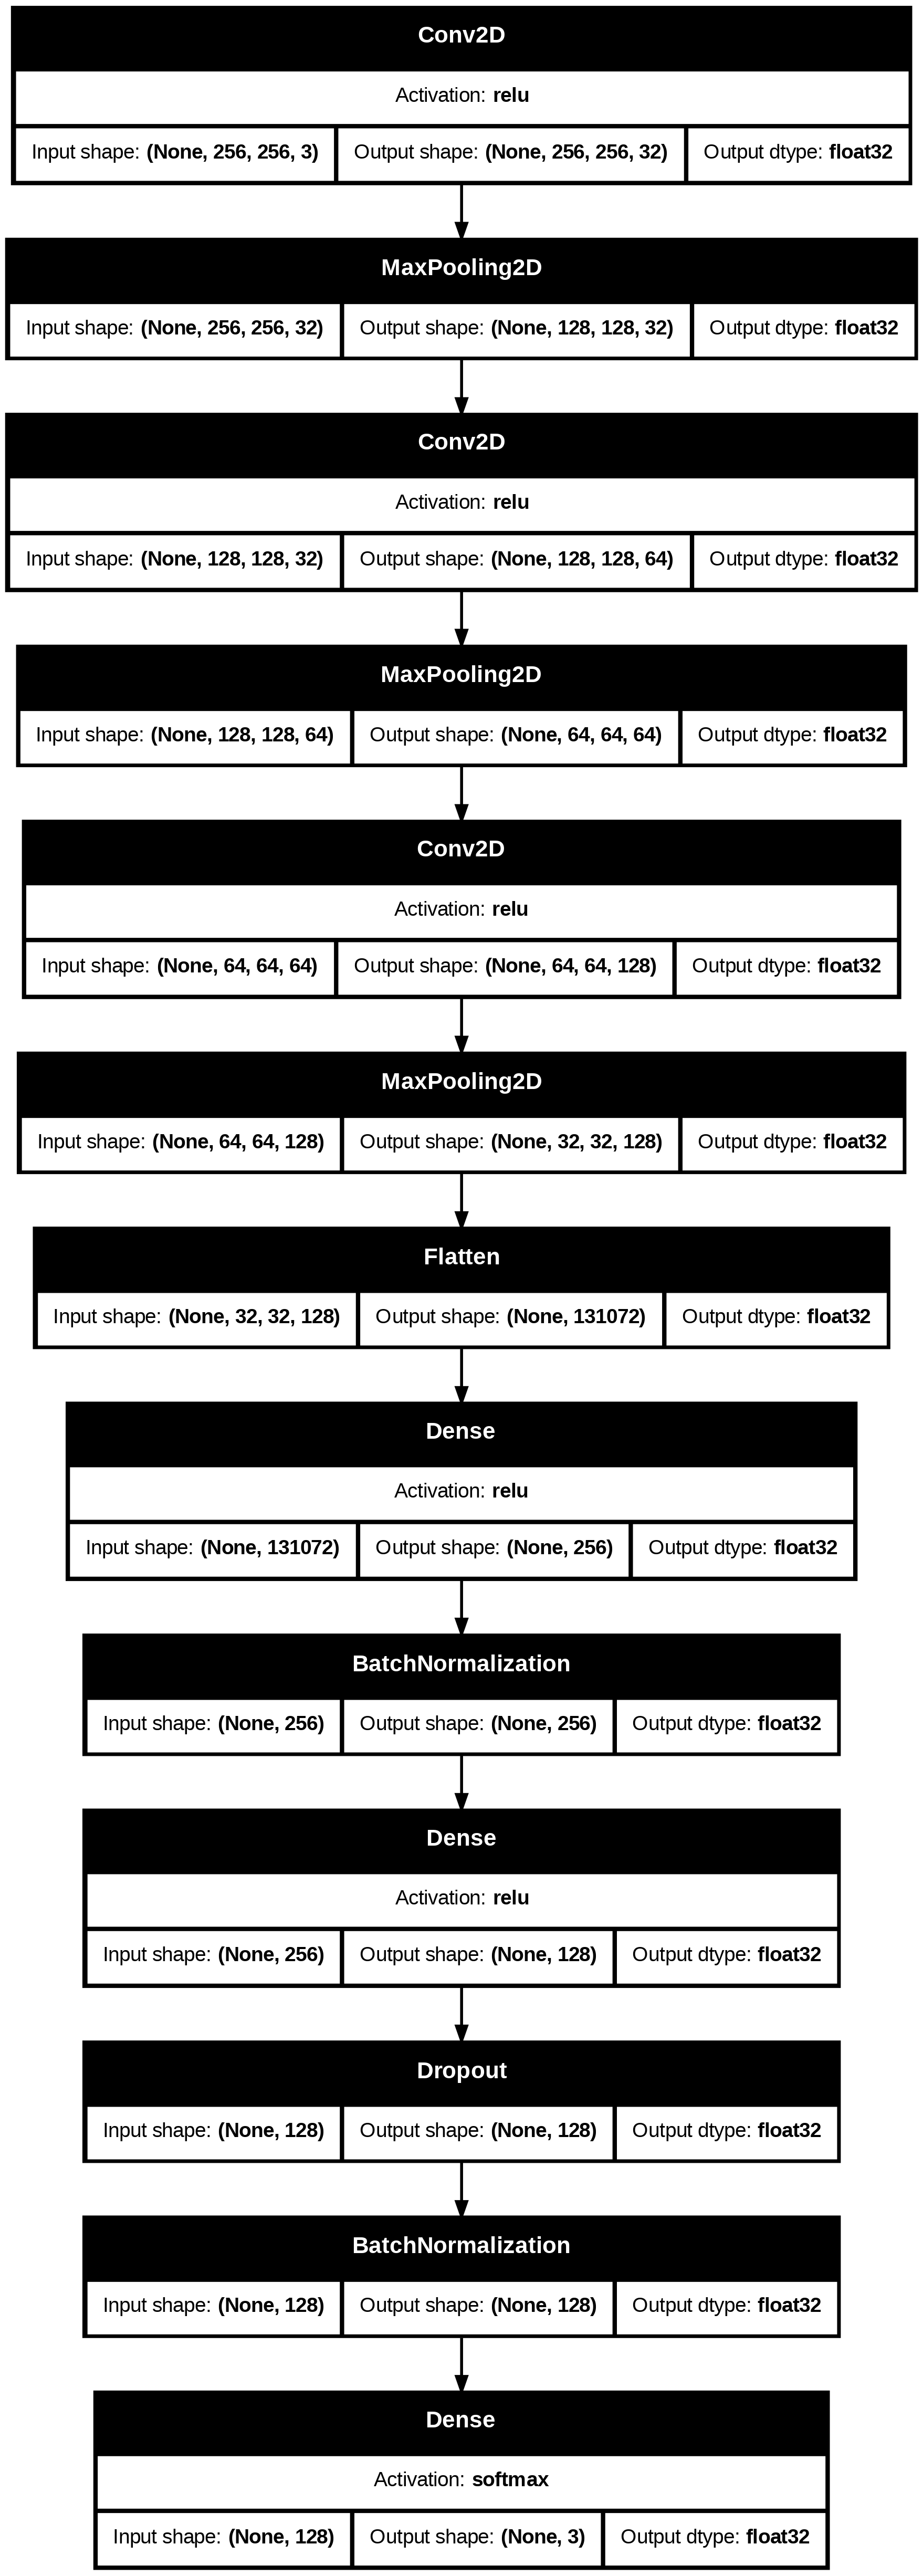

In [16]:
keras.utils.plot_model(
	model,
	show_shapes = True,
	show_dtype = True,
	show_layer_activations = True
)


In [17]:
model.compile(
	optimizer = 'adam',
	loss = 'categorical_crossentropy',
	metrics = ['accuracy']
)


In [18]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if logs.get('val_accuracy') > 0.90:
			print('\n Validation accuracy has reached upto \
					90% so, stopping further training.')
			self.model.stop_training = True


es = EarlyStopping(patience=3,
				monitor='val_accuracy',
				restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss',
					patience=2,
					factor=0.5,
					verbose=1)


In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the path to the lung image sets
lung_path = 'lung_cancer_data/lung_colon_image_set/lung_image_sets'

# Categories in lung_image_sets
lung_categories = ['lung_aca', 'lung_scc', 'lung_n']

# Create an ImageDataGenerator for training and validation
train_datagen = ImageDataGenerator(rescale=1./255)  # Rescale pixel values to [0, 1]
val_datagen = ImageDataGenerator(rescale=1./255)

# Create train and validation generators
train_generator = train_datagen.flow_from_directory(
    lung_path,  # Path to the lung dataset
    classes=lung_categories,  # Categories in lung dataset
    target_size=(IMG_SIZE, IMG_SIZE),  # Resize images to IMG_SIZE
    batch_size=BATCH_SIZE,  # Set batch size
    class_mode='categorical'  # Use categorical cross-entropy
)

val_generator = val_datagen.flow_from_directory(
    lung_path,  # Path to the lung dataset
    classes=lung_categories,  # Categories in lung dataset
    target_size=(IMG_SIZE, IMG_SIZE),  # Resize images to IMG_SIZE
    batch_size=BATCH_SIZE,  # Set batch size
    class_mode='categorical'  # Use categorical cross-entropy
)

# Train the model using the generators
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    verbose=1
)


Found 15000 images belonging to 3 classes.
Found 15000 images belonging to 3 classes.
Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 174s 674ms/step - accuracy: 0.8141 - loss: 0.4585 - val_accuracy: 0.4193 - val_loss: 13.0064
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 176s 619ms/step - accuracy: 0.9074 - loss: 0.2294 - val_accuracy: 0.7556 - val_loss: 0.5298
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 138s 586ms/step - accuracy: 0.9218 - loss: 0.1924 - val_accuracy: 0.8202 - val_loss: 0.3901
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 156s 664ms/step - accuracy: 0.9427 - loss: 0.1472 - val_accuracy: 0.7471 - val_loss: 0.5925
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 138s 589ms/step - accuracy: 0.9502 - loss: 0.1311 - val_accuracy: 0.3523 - val_loss: 20.9340
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 145s 616ms/step - accuracy: 0.9610 - loss: 0.1030 - val_accuracy: 0.5445 - val_loss: 4.9889
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 137s 583ms/step - accuracy: 0.9683 - loss: 0.0825 - val_accuracy: 0.3333 - val_l

In [21]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [22]:
model.save('/content/drive/MyDrive/lung_cancer_cnn_model.h5')
print("Model saved in Google Drive successfully!")


Model saved in Google Drive successfully!


In [23]:
model.save("lung_cancer_cnn_model.h5")
print("Model saved successfully in Colab storage!")


Model saved successfully in Colab storage!


In [24]:
from google.colab import files
files.download("lung_cancer_cnn_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
from tensorflow.keras.models import load_model

model_path = '/content/drive/MyDrive/lung_cancer_cnn_model.h5'  # Adjust path if needed
model = load_model(model_path)
print("Model loaded successfully!")


Model loaded successfully!


In [3]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("Model compiled successfully!")


Model compiled successfully!


In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the path to the lung image sets
lung_path = 'lung_cancer_data/lung_colon_image_set/lung_image_sets'

# Categories in lung_image_sets
lung_categories = ['lung_aca', 'lung_scc', 'lung_n']

# Create an ImageDataGenerator for training and validation
train_datagen = ImageDataGenerator(rescale=1./255)  # Rescale pixel values to [0, 1]
val_datagen = ImageDataGenerator(rescale=1./255)

# Create train and validation generators
train_generator = train_datagen.flow_from_directory(
    lung_path,  # Path to the lung dataset
    classes=lung_categories,  # Categories in lung dataset
    target_size=(IMG_SIZE, IMG_SIZE),  # Resize images to IMG_SIZE
    batch_size=BATCH_SIZE,  # Set batch size
    class_mode='categorical'  # Use categorical cross-entropy
)

val_generator = val_datagen.flow_from_directory(
    lung_path,  # Path to the lung dataset
    classes=lung_categories,  # Categories in lung dataset
    target_size=(IMG_SIZE, IMG_SIZE),  # Resize images to IMG_SIZE
    batch_size=BATCH_SIZE,  # Set batch size
    class_mode='categorical'  # Use categorical cross-entropy
)




Found 15000 images belonging to 3 classes.
Found 15000 images belonging to 3 classes.


In [ ]:
loss, accuracy = model.evaluate(val_generator, verbose=1)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")


 49/235 ━━━━━━━━━━━━━━━━━━━━ 12:44 4s/step - accuracy: 0.9315 - loss: 0.2321